In [1]:
# pip install ipympl
# pip install mpl_point_clicker

# Common Libraries

In [1]:
import os
import sys
import json
import numpy as np
import nibabel as nb
import pandas as pd
from pathlib import Path
import matplotlib.pylab as plt
from mpl_point_clicker import clicker

# Custom Libraries

In [2]:
sys.path.append("/home/seojin")
import surfAnalysisPy as surf # Dierdrichsen lab's library

sys.path.append("/home/seojin/Seojin_commonTool/Module")
from surface_analysis import vol_to_surf, sulcus_abbreviation_name
from sj_brain_mask import fan_roi_mask_manager, brain_mask

# Params

In [3]:
reference_img = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/roi/mask/group_mask.nii.gz"
surf_hemisphere = "R" # L: Left, R: right
surf_resolution = 32

surf_dir_path = f"/mnt/sda2/Common_dir/Atlas/Surface/fs_LR_{surf_resolution}"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")

sulcus_path = os.path.join(surf_dir_path, "borders", f"{surf_hemisphere}_sulcus.json")

surface_mask_dir_path = os.path.join(surf_dir_path, "FAN")
os.makedirs(surface_mask_dir_path, exist_ok = True)

# Load surface data

In [4]:
temploate_surface_data = nb.load(template_surface_path)
vertex_data = temploate_surface_data.darrays[0].data

n_vertex, _ = vertex_data.shape

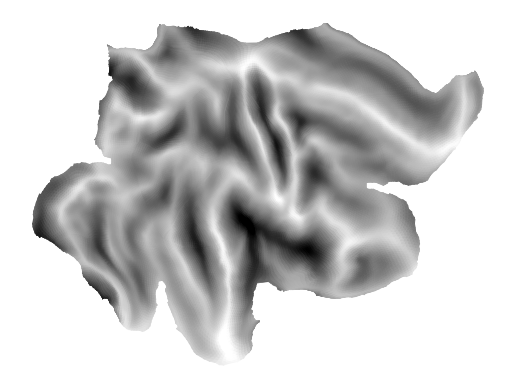

In [5]:
surf_ax = surf.plot.plotmap(data = np.zeros(n_vertex), 
                            surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                            threshold = 0.01)

In [6]:
# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Region Growing 알고리즘
def region_growing(data, seed_index, threshold=1.0):
    visited = set()  # 방문한 좌표
    queue = [seed_index]  # 탐색 큐
    region = []  # 결과 영역

    while queue:
        current_index = queue.pop(0)
        if current_index in visited:
            continue

        # 현재 좌표를 결과에 추가하고 방문 처리
        visited.add(current_index)
        region.append(data[current_index])

        # 현재 좌표
        current_point = data[current_index]

        # 모든 다른 점들과 거리 계산
        for idx, point in enumerate(data):
            if idx not in visited and euclidean_distance(current_point, point) <= threshold:
                queue.append(idx)

    return np.array(region)

# Sulcus drawing

In [7]:
if os.path.exists(sulcus_path):
    with open(sulcus_path, "r") as file:
        marking_data_info = json.load(file)
else:
    marking_data_info = {}

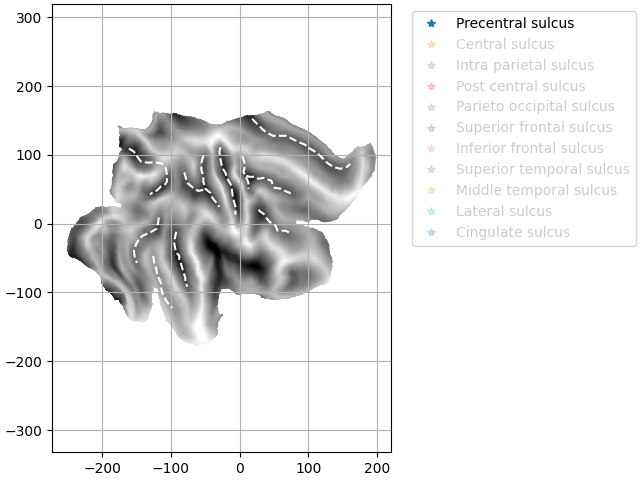

In [8]:
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True)
marking_labels = ["Precentral sulcus",
                  "Central sulcus", 
                  "Intra parietal sulcus",
                  "Post central sulcus",
                  "Parieto occipital sulcus",
                  "Superior frontal sulcus",
                  "Inferior frontal sulcus",
                  "Superior temporal sulcus",
                  "Middle temporal sulcus",
                  "Lateral sulcus",
                  "Cingulate sulcus"]
klicker = clicker(ax, marking_labels, markers = np.repeat("*", len(marking_labels)))

ax_ = surf.plot.plotmap(data = np.zeros(n_vertex), 
                        surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                        threshold = 0.01)
ax_.grid(True)
ax_.axis("on")

for sulcus_name in marking_data_info:
    ax_.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
             np.array(marking_data_info[sulcus_name])[:, 1], 
             color = "white",  
             linestyle = "dashed")

In [11]:
# Save sulcus
click_info = klicker.get_positions()
for sulcus_name in click_info:
    if len(click_info[sulcus_name]) > 0:
        marking_data_info[sulcus_name] = np.array(click_info[sulcus_name]).tolist()

In [12]:
with open(sulcus_path, "w") as file:
    json.dump(marking_data_info, file)

# Show sulcus

In [12]:
n_vertex, _ = vertex_data.shape

surf_ax = surf.plot.plotmap(data = np.zeros(n_vertex), 
                            surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                            threshold = 0.01)

for sulcus_name in marking_data_info:
    if sulcus_name == "Cingulate sulcus":
        print(sulcus_name)
    else:
        continue
    surf_ax.plot(np.array(marking_data_info[sulcus_name])[:, 0], 
                 np.array(marking_data_info[sulcus_name])[:, 1], 
                 color = "white",  
                 linestyle = "dashed")
    x = np.mean(np.array(marking_data_info[sulcus_name])[:, 0])
    y = np.max(np.array(marking_data_info[sulcus_name])[:, 1]) + 5
    surf_ax.text(x = x, 
                 y = y, 
                 s = sulcus_abbreviation_name(sulcus_name), 
                 color = "white", 
                 horizontalalignment = "center", 
                 verticalalignment = "center",
                 size = 10)

Cingulate sulcus
